____
# SYNTHETIC DATA GENERATION ON POINT CLOUD
____

<a id='0'></a>

# SOMMAIRE

-  [I - LOAD, UTILS FUNCTIONS](#1)&nbsp;

-  [II - POINT CLOUD AUGMENTATION](#2)
    -  [1. Random Shrink](#2_1)
    -  [2. Random Rotatation](#2_2)
    -  [3. Non Uniform Density](#2_3)
    
-  [III -   VOXELISATION & FURTHER AUGMENTATION](#3)
    -  [1. Voxelisation](#3_1)
    -  [2. Blur](#3_2)
    -  [3. Noise](#3_3)

____

> On se concentre ici sur le traitement d'*une particule* donc on ne s'intéressera pas à la génération d'outliers.

<a id='1'></a>

In [1]:
import os
os.chdir('/home/plumail/stage/minisource')
import numpy as np
from typing import Tuple, List

____
# I - LOAD, UTILS FUNCTIONS
____

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors 
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [3]:
point_cloud_path = '/data1/stage_Luc/inputs/sample_centriole_point_cloud.csv'

In [4]:
point_cloud = np.loadtxt(point_cloud_path, delimiter=',')
print(f"Point Cloud Shape: {point_cloud.shape}")

Point Cloud Shape: (89991, 3)


Je commence par définir trois fonctions utiles pour la suite:   
- __plot_3d__ permet de faire un affichage interactif d'un nuage de point, coloré éventuellement en fonction de labels.
- __plot_3D_views__ permet d'afficher une image 3D suivant 3 points de vues. Utile pour voir le résultat de la voxelisation.
- __resample__ permet de réduire le nombre de points dans un nuage de points d'un facteur donnée. Sert principalement à réduire facilement le temps de calcul.

> Pour afficher des plots 3d interactifs, il ya deux options:     
    1. Plot dans le notebook, en mettant %matplotlib widget (disponible de base avec jupyterlab >= 3.0, sinon à installer).      
    2. Plot dans une fenêtre, en mettant %matplotlib auto.       
    Les plots dynamiques sont disponibles dans un jupyter lab mais pas dans un jupyter notebook ou dans visual studio code.         

In [5]:
def plot_3d(
    point_cloud: np.ndarray,
    ax: Axes3D=None,
    elev: float=90, 
    azim: float=0,
    figsize: Tuple[int]=(10, 10),
    size: float=0.1,
    colormap='cividis'
) -> None:
    """ A simple 3d point cloud plot.
    
    Args:
        point_cloud (np.ndarray): Array of shape (num_points, 3).
        ax (Axes3D, optional): If the plot is to be integrated within a figure, an ax can be specified.
                               If None, an axe will be created and display will be handled.
                               Defaults to None.
        elev, azim (floats, optionals): Camera position. Angles in degrees. Defaults to (90, 0).
        figsize (Tuple[int]): If ax is None, a figure will be created. This figures's width and height
                              can be specified here. Defaults to (10, 10).
    """
    plot_later = True
    if ax is None:
        plot_later = False
        fig = plt.figure(figsize=figsize)
        ax = Axes3D(fig, elev=elev, azim=azim)
    plt.set_cmap(colormap)
    ax.scatter(point_cloud[:,0], point_cloud[:,1], point_cloud[:,2], c=point_cloud[:,2], s=size)
    if not plot_later:
        plt.show()

In [6]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def slice_in_3D(ax, slice_index=0, dim=0, zpos=0, shape=(100, 100, 100)):
    # From https://stackoverflow.com/questions/44881885/python-draw-3d-cube
    Z = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
                  [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]])
    Z = Z * shape
    r = [-1, 1]
    X, Y = np.meshgrid(r, r)
    # Plot vertices
    ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])
    # List sides' polygons of figure
    verts = [[Z[0], Z[1], Z[2], Z[3]],
             [Z[4], Z[5], Z[6], Z[7]],
             [Z[0], Z[1], Z[5], Z[4]],
             [Z[2], Z[3], Z[7], Z[6]],
             [Z[1], Z[2], Z[6], Z[5]],
             [Z[4], Z[7], Z[3], Z[0]],
             [Z[2], Z[3], Z[7], Z[6]]]
    # Plot sides
    sides = Poly3DCollection(verts,
                             facecolors=(1, 1, 1, 0.25), linewidths=1, edgecolors="black")
    ax.add_collection3d(sides)
    # Plot slice
    verts = [
        [[0, 0, 0], [0, 0, 1], [0, 1, 1], [0, 1, 0]],
        [[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1]],
        [[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]]
    ]
    verts = np.array([verts[dim]])
    verts = verts * shape
    add = [0, 0, 0]
    add[dim] = slice_index
    verts   += add
    colors = ['red', 'green', 'blue']
    _slice = Poly3DCollection(verts, sort_zpos=zpos, facecolors=colors[dim],
                              alpha=0.9, linewidths=1, edgecolors="black")
    ax.add_collection3d(_slice)

    ax.set_xlabel("z")
    ax.set_ylabel("y")
    ax.set_zlabel("x")

    # Autoscale plot axes
    scaling = np.array([getattr(ax, f'get_{dim}lim')() for dim in "xyz"])
    ax.auto_scale_xyz(* [[np.min(scaling), np.max(scaling)]] * 3)

def plot_3D_views(
    image: np.ndarray,
    x: int=None,
    y: int=None,
    z: int=None,
    figsize: Tuple[int]=(15, 15),
    grid: bool=True,
    channel_dim: bool=False,
) -> None:
    _  = plt.figure(figsize=figsize)
    xy = plt.subplot2grid((4, 4), (0, 0),   rowspan=2, colspan=2)
    zy = plt.subplot2grid((4, 4), (0, 2),   rowspan=2, colspan=2)
    xz = plt.subplot2grid((4, 4), (2, 0),   rowspan=2, colspan=2)
    cube = plt.subplot2grid((4, 4), (2, 2), rowspan=2, colspan=2, projection="3d")
    xy.set_xlabel('x', fontsize=25, color='red')
    zy.set_xlabel('z', fontsize=25, color='red', labelpad=100)
    zy.set_ylabel('y', fontsize=25, color='red')
    shape = image.shape[:-1] if channel_dim else image.shape
    y_view = (2, 1, 0, 3) if channel_dim else (2, 1, 0)
    x_view = (1, 0, 2, 3) if channel_dim else (1, 0, 2)
    d, h, w = shape
    x_coord = x if x is not None else w // 2
    y_coord = y if y is not None else h // 2
    z_coord = z if z is not None else d // 2
    xy.imshow(image[z_coord], cmap='gray')
    zy.imshow(image.transpose(y_view)[x_coord], cmap='gray')
    xz.imshow(image.transpose(x_view)[y_coord], cmap='gray')
    slice_in_3D(cube, slice_index=z_coord, dim=0, zpos=0, shape=shape)
    slice_in_3D(cube, slice_index=y_coord, dim=1, zpos=1, shape=shape)
    slice_in_3D(cube, slice_index=x_coord, dim=2, zpos=2, shape=shape)
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    if grid:
        xy.grid()
        zy.grid()
        xz.grid()
    plt.show()

In [7]:
def resample(point_cloud: np.ndarray, sample_factor: int=10) -> np.ndarray:
    """ Uniformly sample a list of points by a factor given by sample_factor,
    that is keep one point every sample_factor points.
    
    Args:
        point_cloud (np.ndarray): List of points, of shape (num_points, 3).
        sample_factor (int): By which factor to divide the number of points.

    Returns:
        (np.ndarray): Sampled list of points, of shape ((num_points//sample_factor) + 1, 3).
    """
    num_points = point_cloud.shape[0]
    indexes_to_keep = list(filter(lambda i: i % sample_factor == 0, range(num_points)))
    return point_cloud[indexes_to_keep]

In [8]:
point_cloud = resample(point_cloud, sample_factor=2)
print(f"Sampled Point Cloud Shape: {point_cloud.shape}")

Sampled Point Cloud Shape: (44996, 3)


/tmp/ipykernel_10953/1492445443.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=elev, azim=azim)


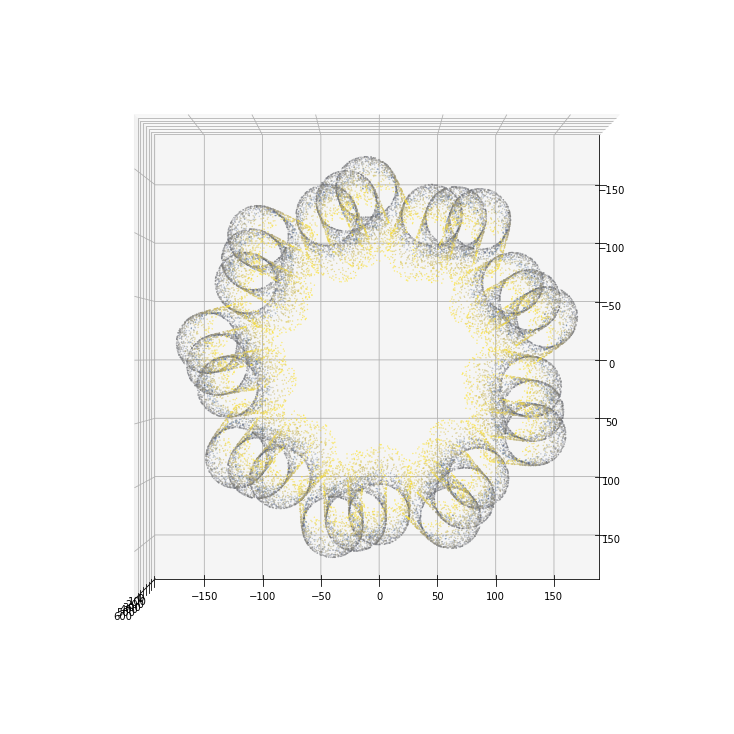

In [9]:
plot_3d(point_cloud, figsize=(10, 10), elev=90, azim=0)

<IPython.core.display.Javascript object>


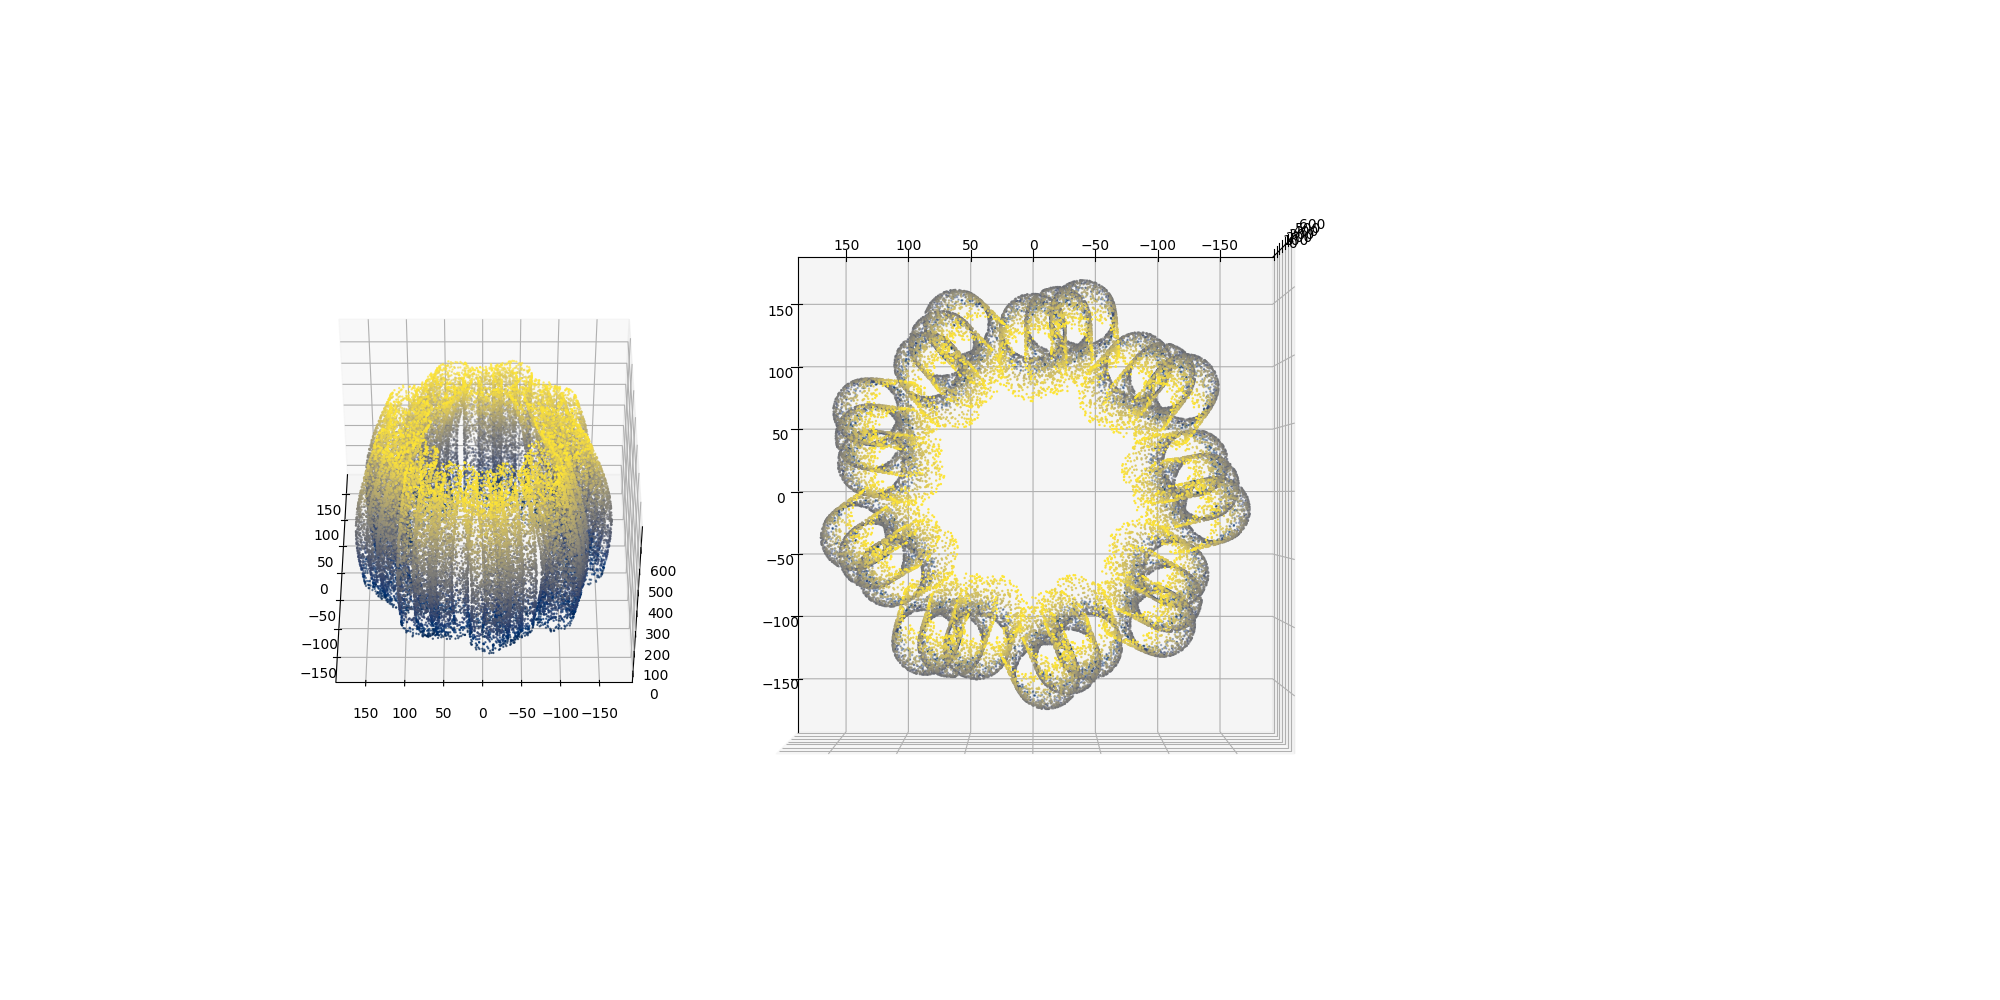

In [11]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111, projection='3d', elev=90, azim=180)
ax2 = fig.add_subplot(131, projection='3d', elev=45, azim=180)

plot_3d(point_cloud, ax=ax1, size=0.5)
plot_3d(point_cloud, ax=ax2, size=0.5)
plt.show()

[Back to top](#0)
<a id='2'></a>
____
# II - SYNTHETIC DATA GENERATION
____

In [12]:
os.chdir("/home/plumail/stage/minisource")

In [13]:
import torch
import modules.pretraining.generate.functional as F

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
point_cloud = torch.as_tensor(point_cloud, dtype=torch.float64).to(device)

In [16]:
def load_point_cloud(path: str) -> torch.Tensor:
    point_cloud = np.loadtxt(point_cloud_path, delimiter=',')
    return torch.as_tensor(point_cloud, dtype=torch.float64).to(device)

<a id='2_1'></a>
## II.1 - Random shrink

On génère un facteur de contraction aléatoire entre 2 et 3 et on divise nos coordonnées par ce facteur.

In [17]:
shrink_range = (2, 3) # shrink factor [min, max]

In [18]:
a, b   = shrink_range
factor = (b - a) * np.random.random_sample() + a
print(f'Shrink factor: {factor:.4f}')
point_cloud = F.shrink(point_cloud, factor)

Shrink factor: 2.3509


<IPython.core.display.Javascript object>


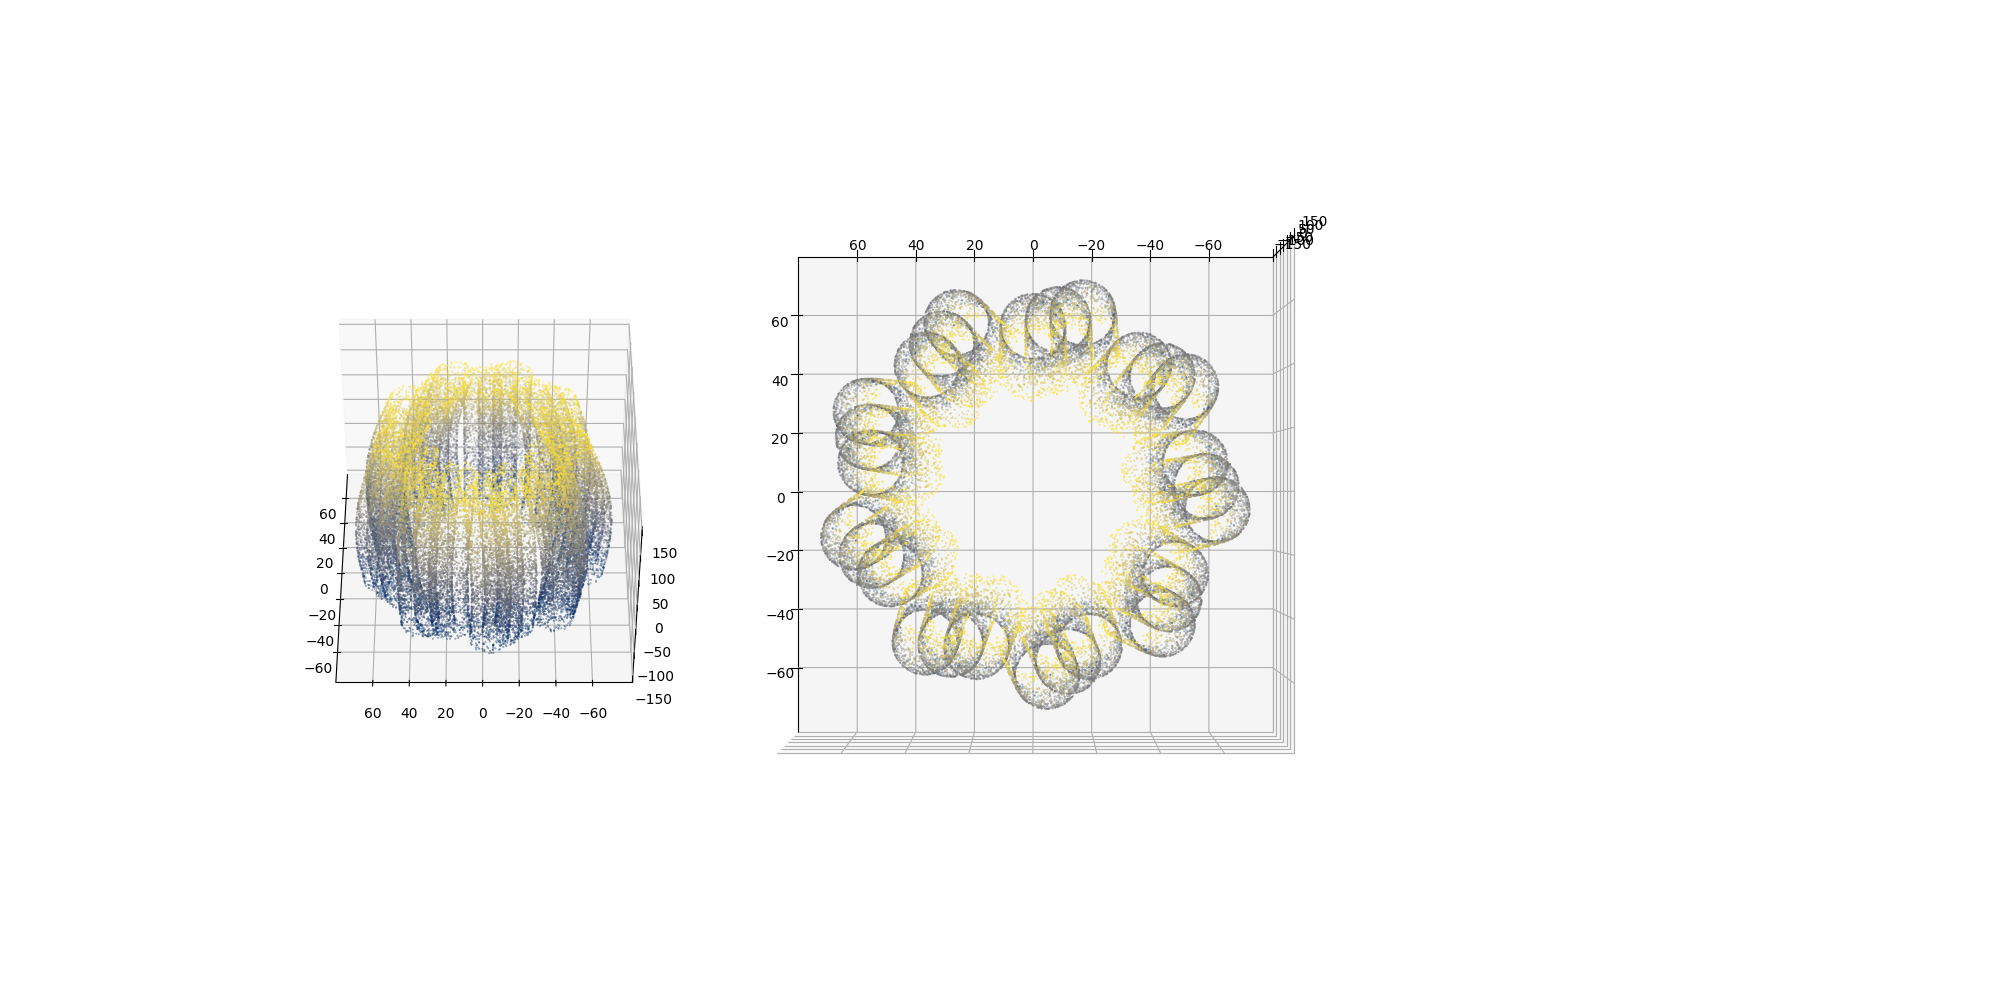

In [19]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111, projection='3d', elev=90, azim=180)
ax2 = fig.add_subplot(131, projection='3d', elev=45, azim=180)

plot_3d(point_cloud.cpu().numpy(), ax=ax1)
plot_3d(point_cloud.cpu().numpy(), ax=ax2)

L'échelle des axes n'est pas la même que le plot d'avant: il y a bien eu une contraction.

[Back to top](#0)
<a id='2_2'></a>

## II.2 - Random Rotation

In [20]:
rotation_proba = 1

On genère trois réels aléatoires entre -180 et 180 qui serviront d'angles d'Euler. Puis on applique directement la fonction rotation de scipy.      
On conserve les angles (pour visualiser l'axe de rotation par exemple, et surtout pour labelliser la vue pour un apprentissage futur).

In [21]:
point_cloud = F.rotate(point_cloud, None, rotation_proba, device)

<IPython.core.display.Javascript object>


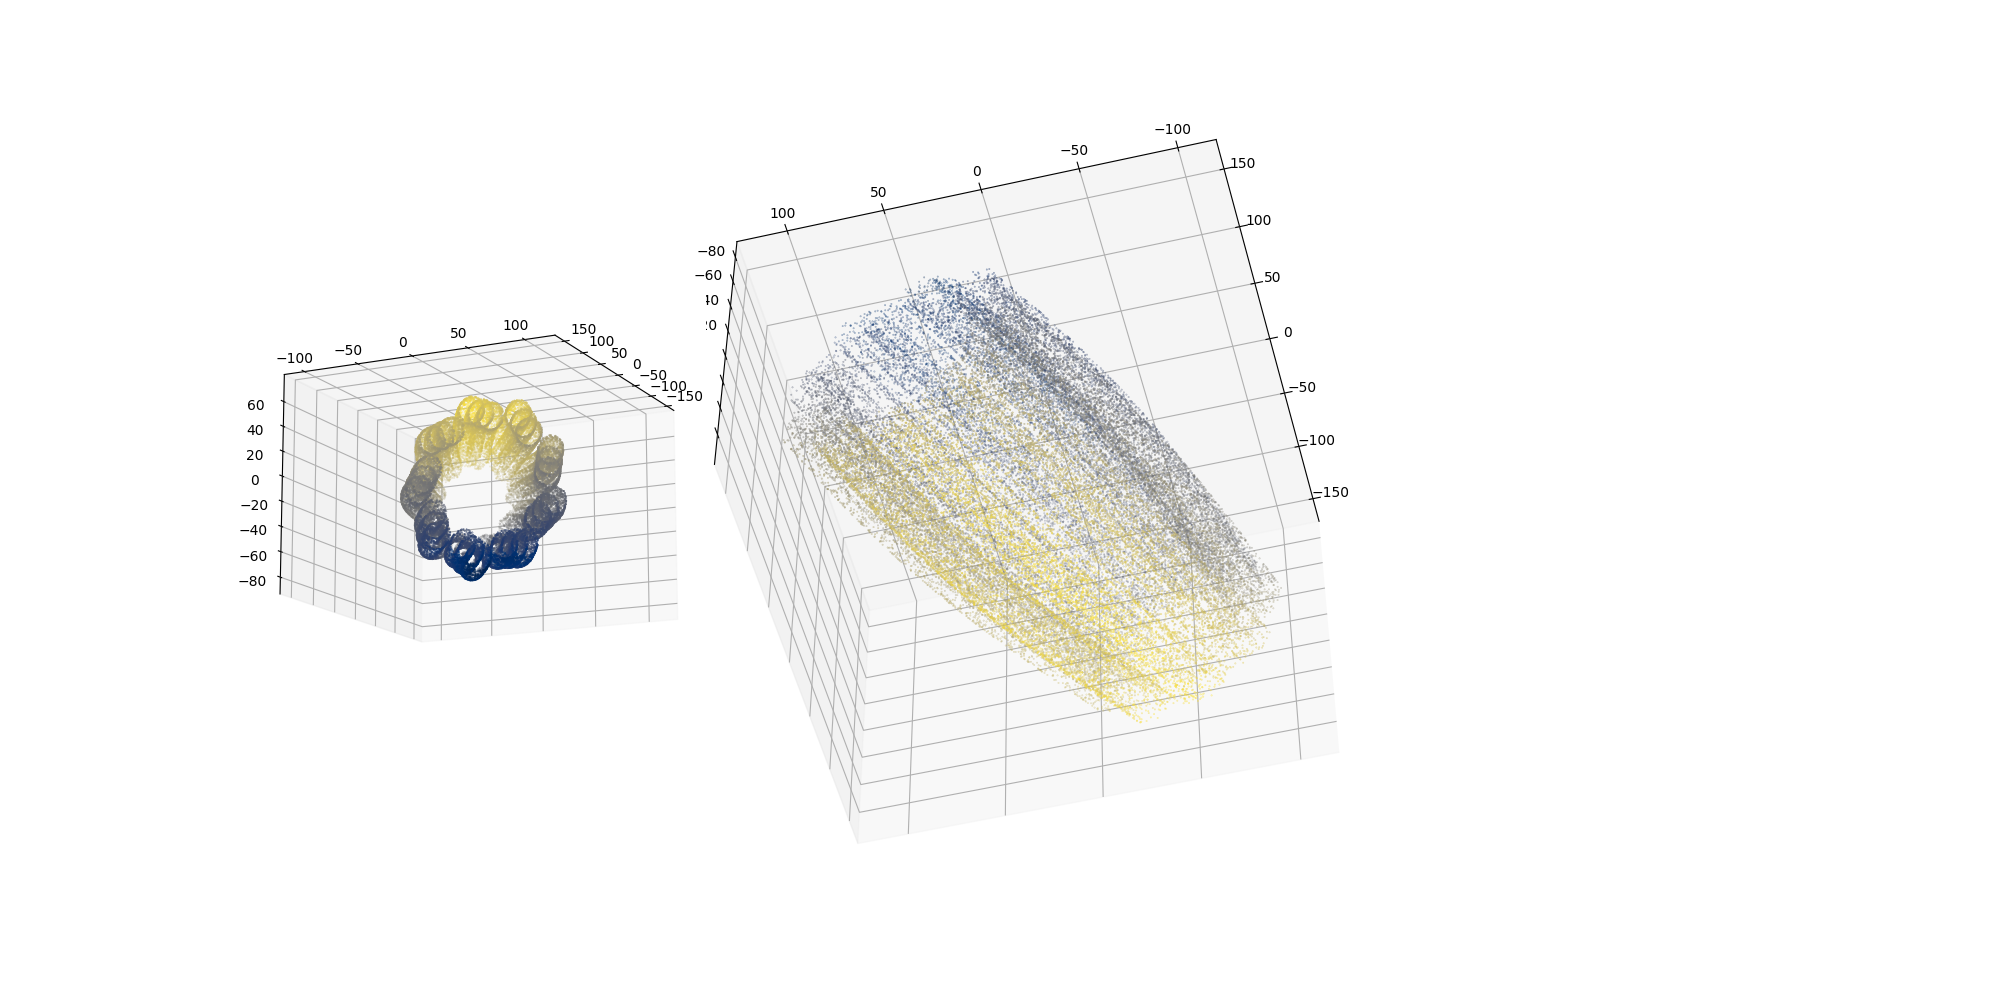

In [22]:
%matplotlib notebook

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111, projection='3d', elev=90, azim=180)
ax2 = fig.add_subplot(131, projection='3d', elev=45, azim=180)

plot_3d(point_cloud.cpu().numpy(), ax=ax1)
plot_3d(point_cloud.cpu().numpy(), ax=ax2)

En gardant le même angle de vue la position de la particule a changé: il y a bien eu une rotation.

[Back to top](#0)
<a id='2_3'></a>
## II.3 - Non Uniform Density 

Cette fonction commence par générer un nombre de positions aléatoires à l'intérieur d'une particule puis dans une sphère autour de chacune des ces positions retire certains points aléatoirement suivant une loi normale (forte proba au centre la sphère, décroissante jusqu'au bord de la sphère). 

In [23]:
num_points_before_nud = point_cloud.size(0)

In [24]:
intensity_nb_holes_min    = 7
intensity_nb_holes_max    = 8
intensity_mean_ratio      = 0.35
intensity_std_ratio_range = (0.15, 0.25)

In [25]:
a, b = intensity_std_ratio_range
std_ratio = (b - a) * np.random.random_sample() + a

In [26]:
point_cloud = F.non_uniform_density(
        point_cloud,
        intensity_nb_holes_min,
        intensity_nb_holes_max,
        intensity_mean_ratio,
        std_ratio,
        device
)

<IPython.core.display.Javascript object>


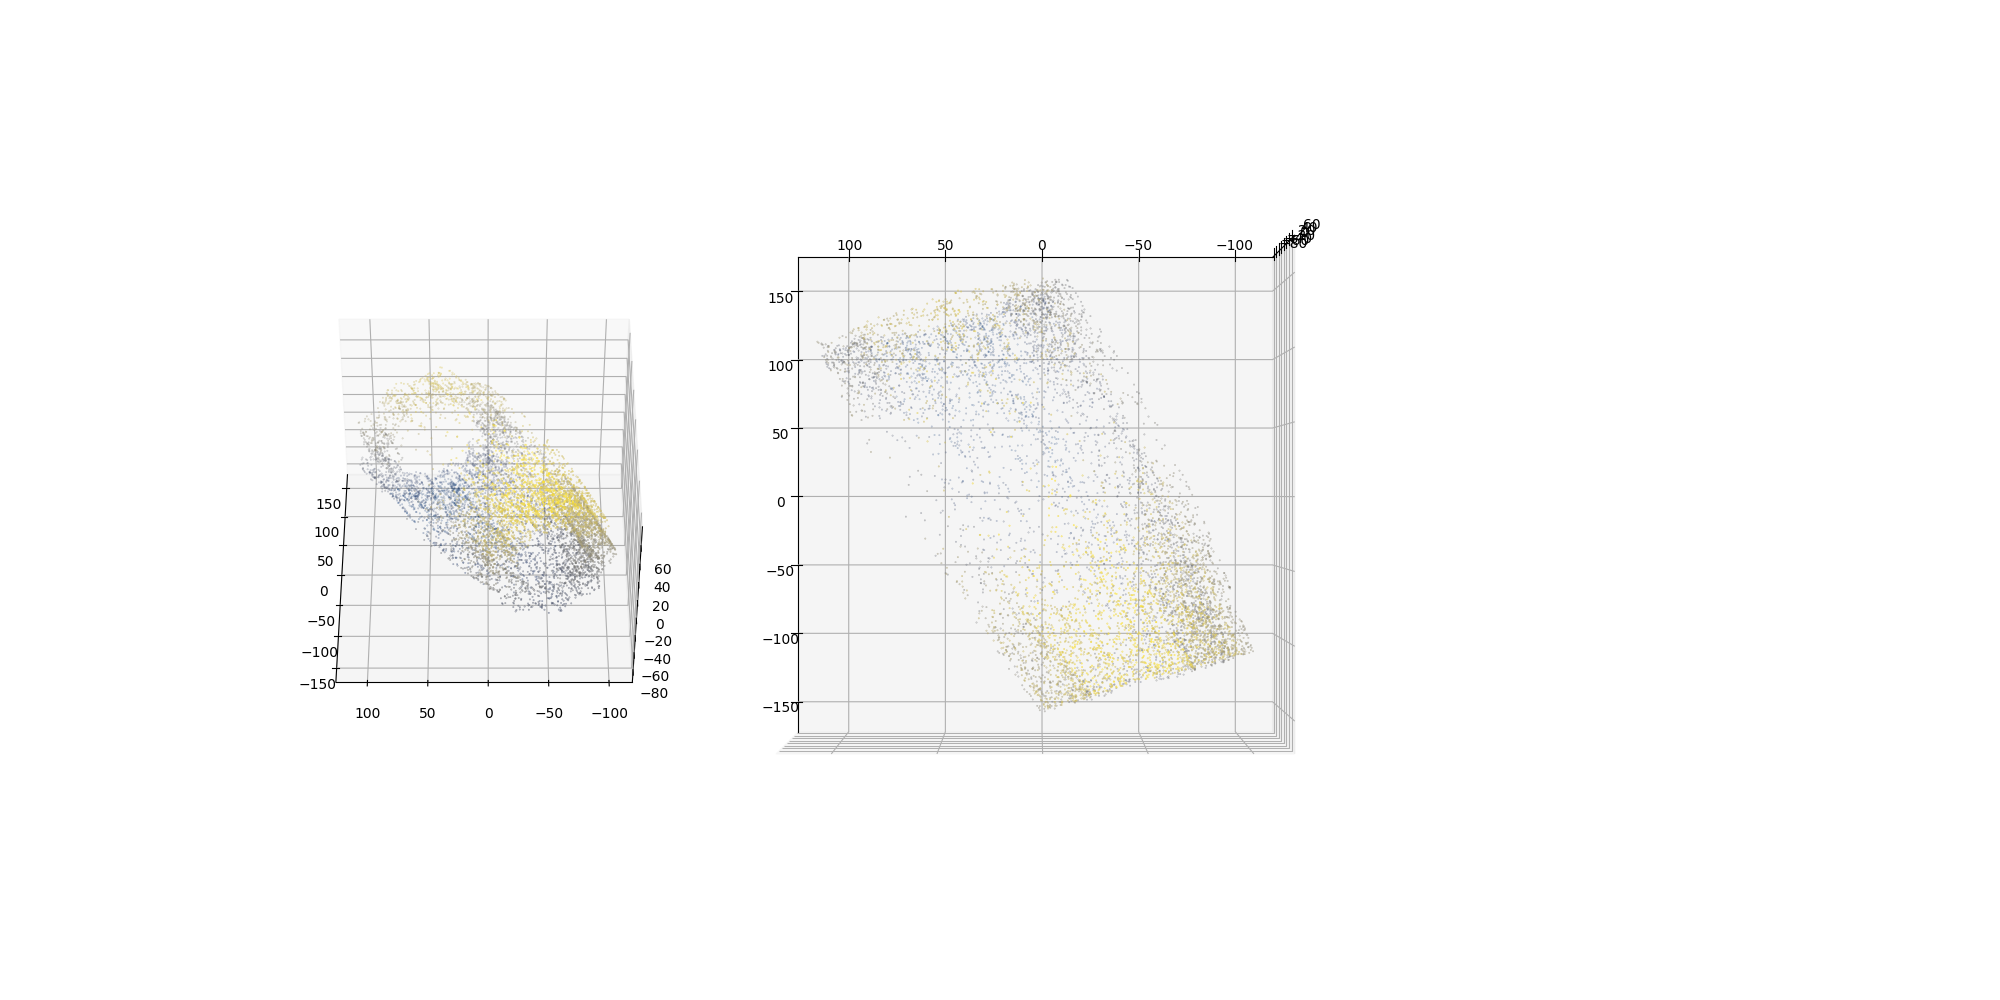

In [27]:
# %matplotlib widget

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111, projection='3d', elev=90, azim=180)
ax2 = fig.add_subplot(131, projection='3d', elev=45, azim=180)

plot_3d(point_cloud.cpu().numpy(), ax=ax1)
plot_3d(point_cloud.cpu().numpy(), ax=ax2)

In [28]:
num_points_after_nud = point_cloud.size(0)

In [29]:
print('Num points before non uniform density simulation: ', num_points_before_nud)
print('Num points after non uniform density simulation.: ', num_points_after_nud)

Num points before non uniform density simulation:  44996
Num points after non uniform density simulation.:  7862


[Back to top](#0)
<a id='3'></a>

___
# III - VOXELISATION & FURTHER AUGMENTATION
___

<a id='3_1'></a>
## III.1 - Voxelisation

In [30]:
from modules.pretraining.generate.figtree.pyfigtree import figtree

In [31]:
def image_from_pointcloud(
    point_cloud: np.ndarray,
    max_particle_dim: int,
    bandwidth: float=5,
    epsilon: float=1e-3
) -> np.ndarray:
    x_min, x_max, y_min, y_max, z_min, z_max = F.get_FOV(point_cloud)
    max_delta = max(x_max - x_min, y_max - y_min, z_max - z_min)
    step = max_delta / max_particle_dim
    x_range = int(np.ceil((x_max - x_min) / step))
    y_range = int(np.ceil((y_max - y_min) / step))
    z_range = int(np.ceil((z_max - z_min) / step))
    target_points = np.mgrid[x_min:x_max:step, y_min:y_max:step, z_min:z_max:step]
    target_points = target_points.reshape(3, -1).T
    weights = np.ones(len(point_cloud))
    densities = figtree(point_cloud, target_points, weights, bandwidth=bandwidth, epsilon=epsilon)
    densities = densities.reshape((x_range, y_range, z_range))
    densities = densities.transpose(2, 0, 1)
    densities = (densities - densities.min()) / (densities.max() - densities.min())
    return densities

In [32]:
max_particle_dim = 150 # max voxel dim

In [33]:
# image = image_from_pointcloud(point_cloud.cpu().numpy(), max_particle_dim)
image = image_from_pointcloud(point_cloud.cpu().numpy(), max_particle_dim)

<IPython.core.display.Javascript object>


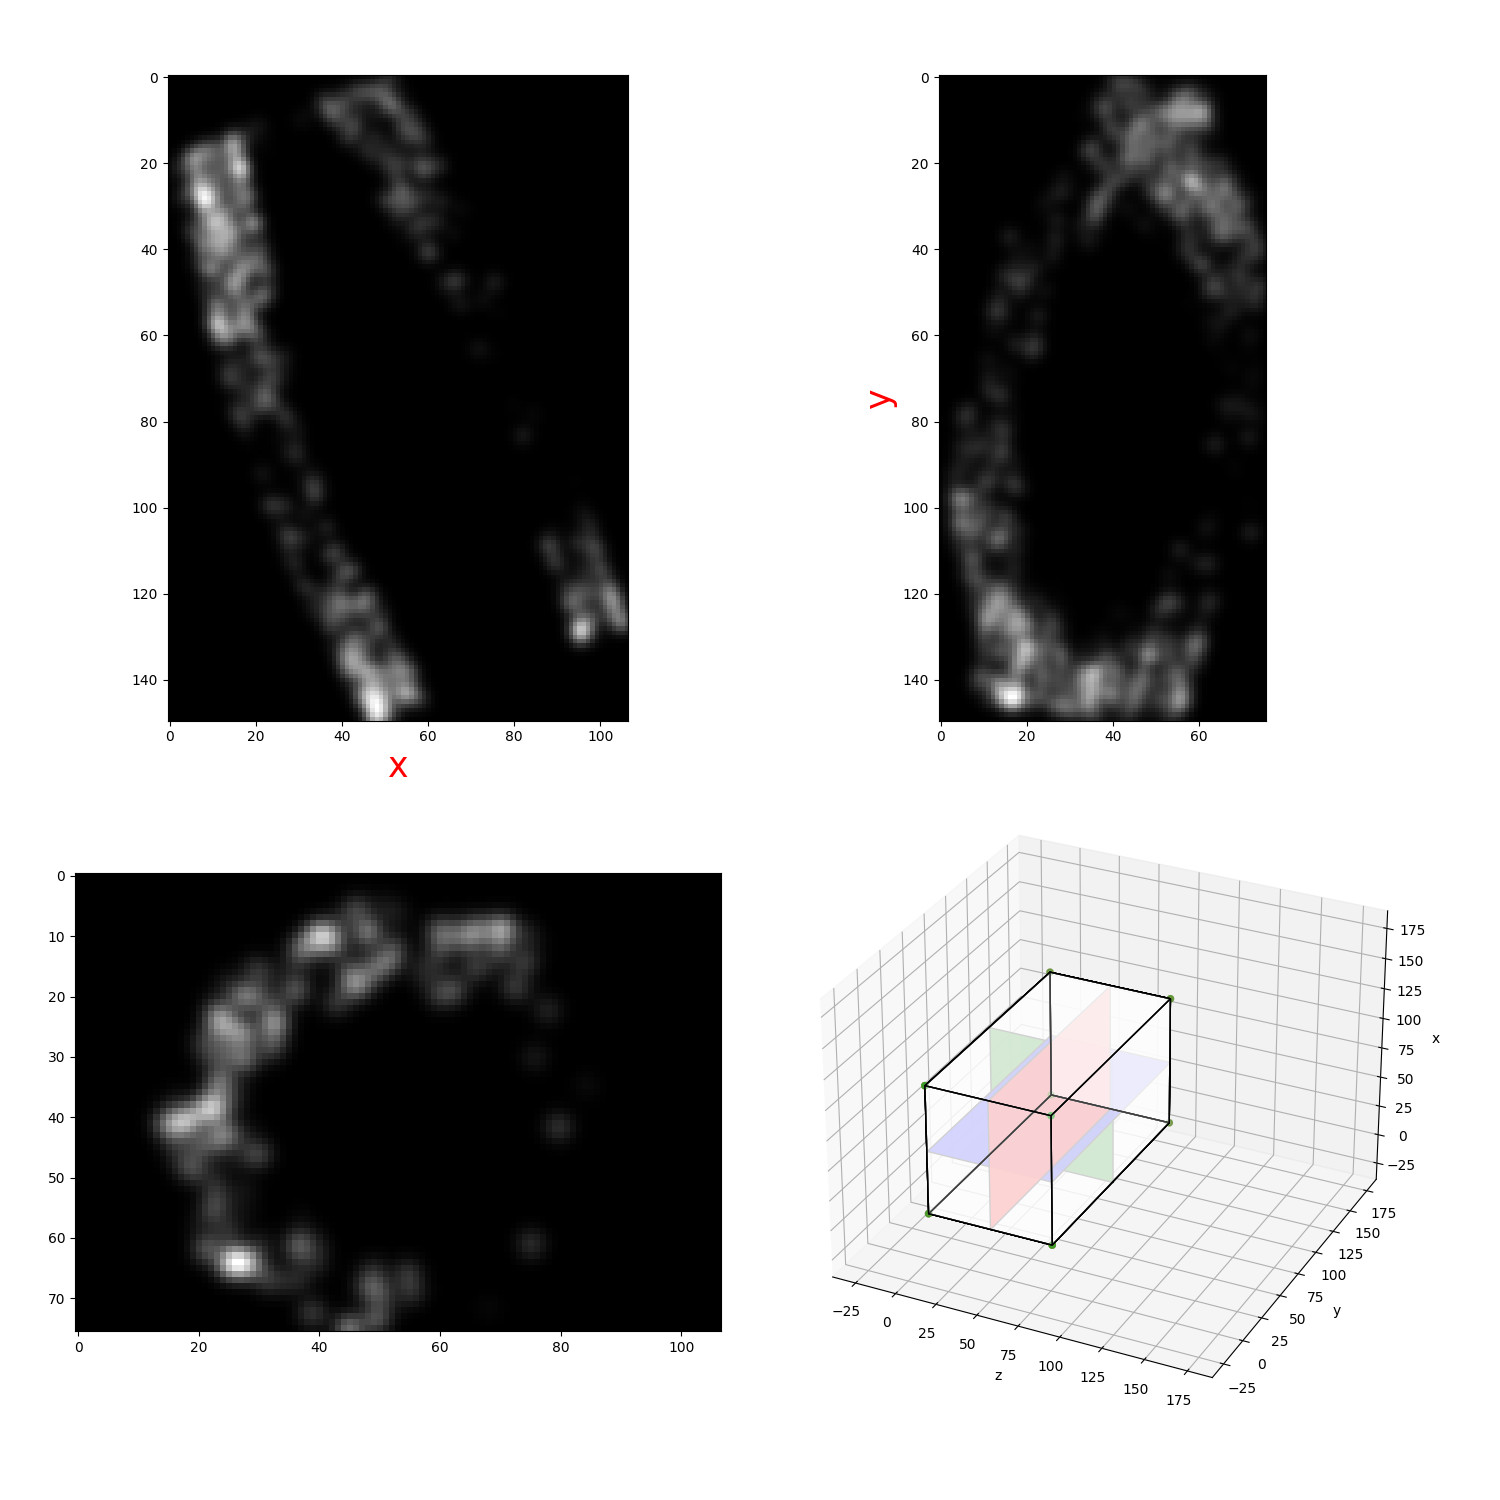

In [34]:
plot_3D_views(image, grid=False)

[Back to top](#0)
<a id='3_2'></a>
## III.2 - Blur

In [35]:
from scipy.ndimage.filters import gaussian_filter # I do think it's faster than skimage's filters.

/tmp/ipykernel_10953/1812567774.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter # I do think it's faster than skimage's filters.


In [36]:
sigma = (5, 1, 1) # strong z-axis resolution anisotropy.
mode  = 'constant'

In [37]:
image = gaussian_filter(image, sigma=sigma, mode=mode)

<IPython.core.display.Javascript object>


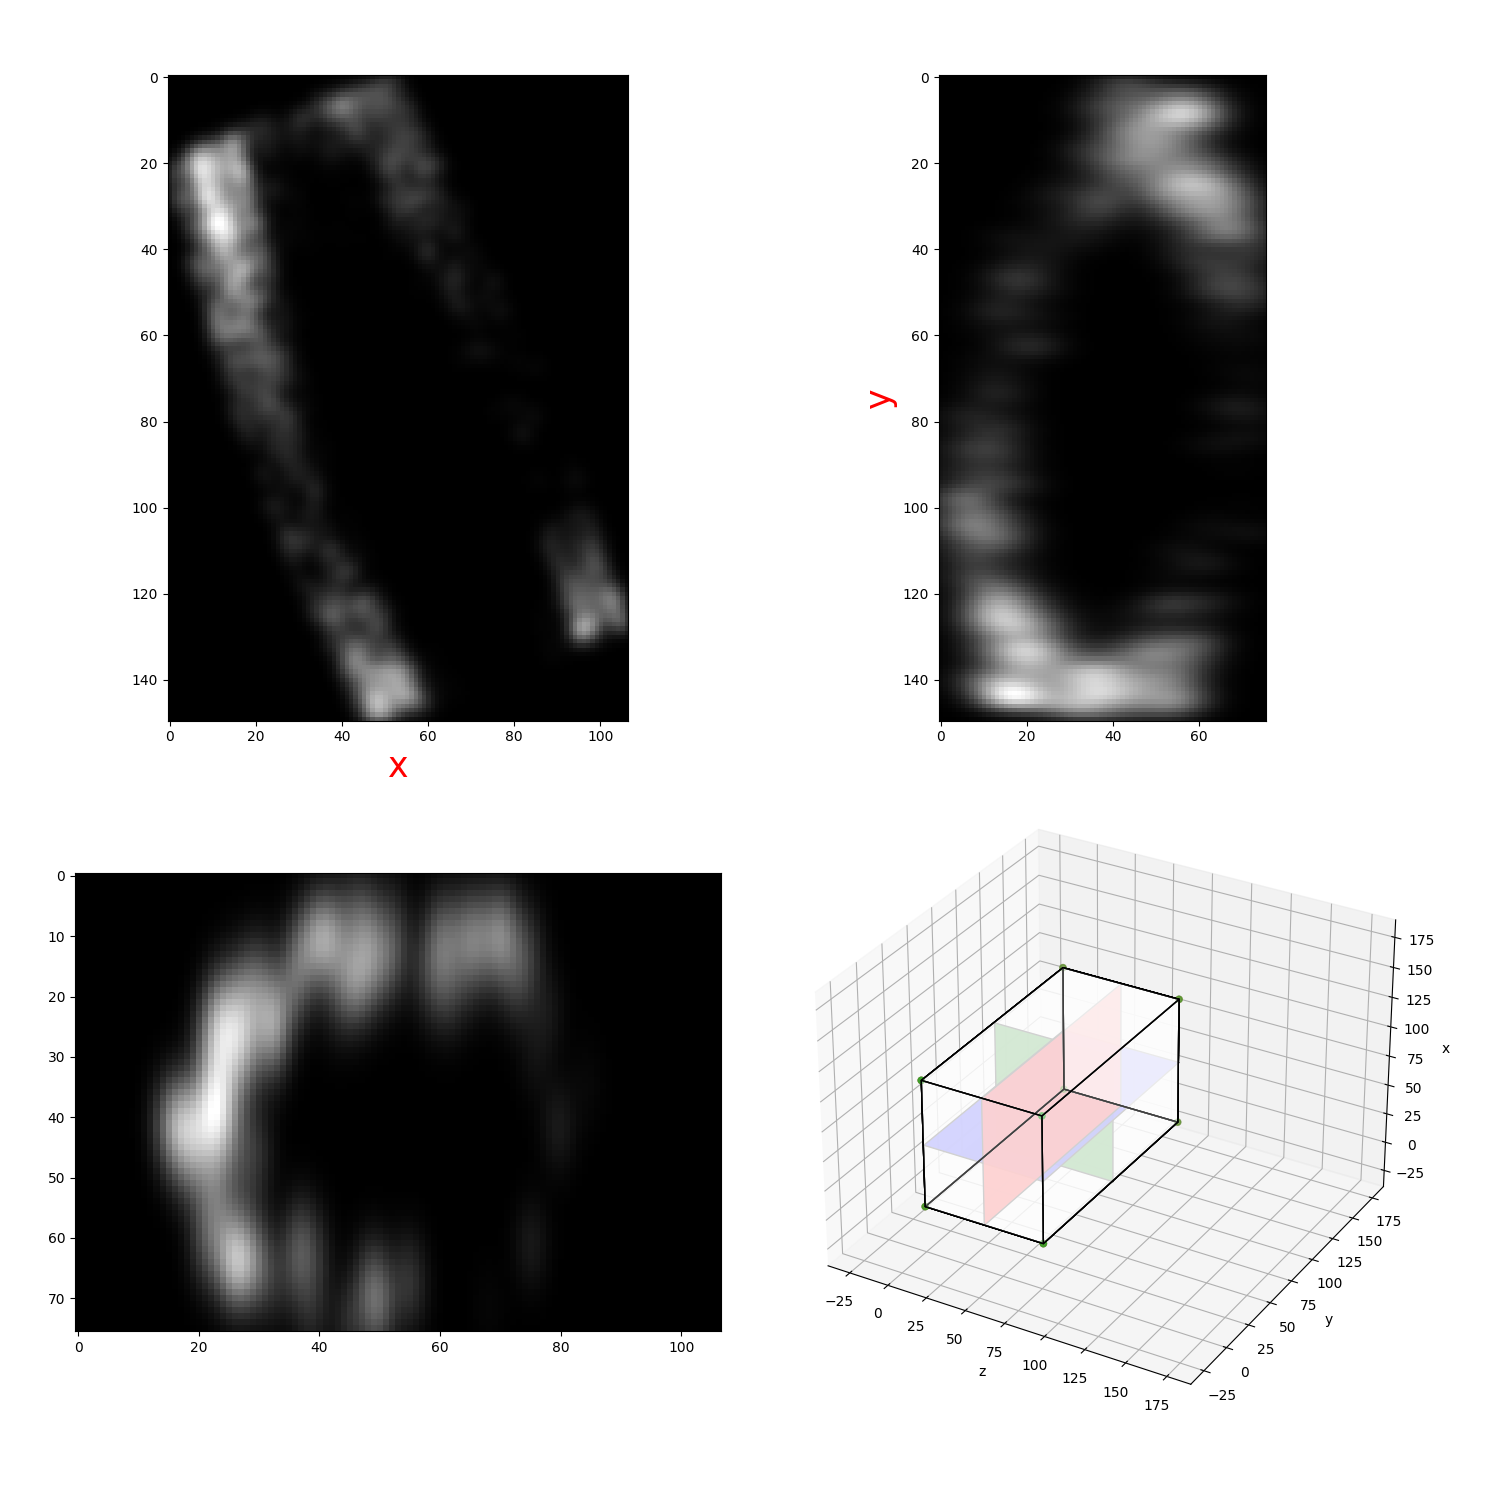

In [38]:
plot_3D_views(image, grid=False)

[Back to top](#0)
<a id='3_3'></a>
## III.3 - Noise

In [39]:
mean = 0.5
target_snr_db = 25

In [40]:
def add_gaussian_noise_with_target_snr(
    image: np.ndarray,
    mean: float,
    target_snr_db: int
) -> np.ndarray:
    image_average_db = 10 * np.log10(image.mean())
    noise_average_db = image_average_db - target_snr_db
    noise_average    = 10 ** (noise_average_db / 10)
    noise = np.random.normal(mean, np.sqrt(noise_average), image.shape)
    image += noise
    return (image - image.min()) / (image.max() - image.min())

In [41]:
image = add_gaussian_noise_with_target_snr(image, mean, target_snr_db)

<IPython.core.display.Javascript object>


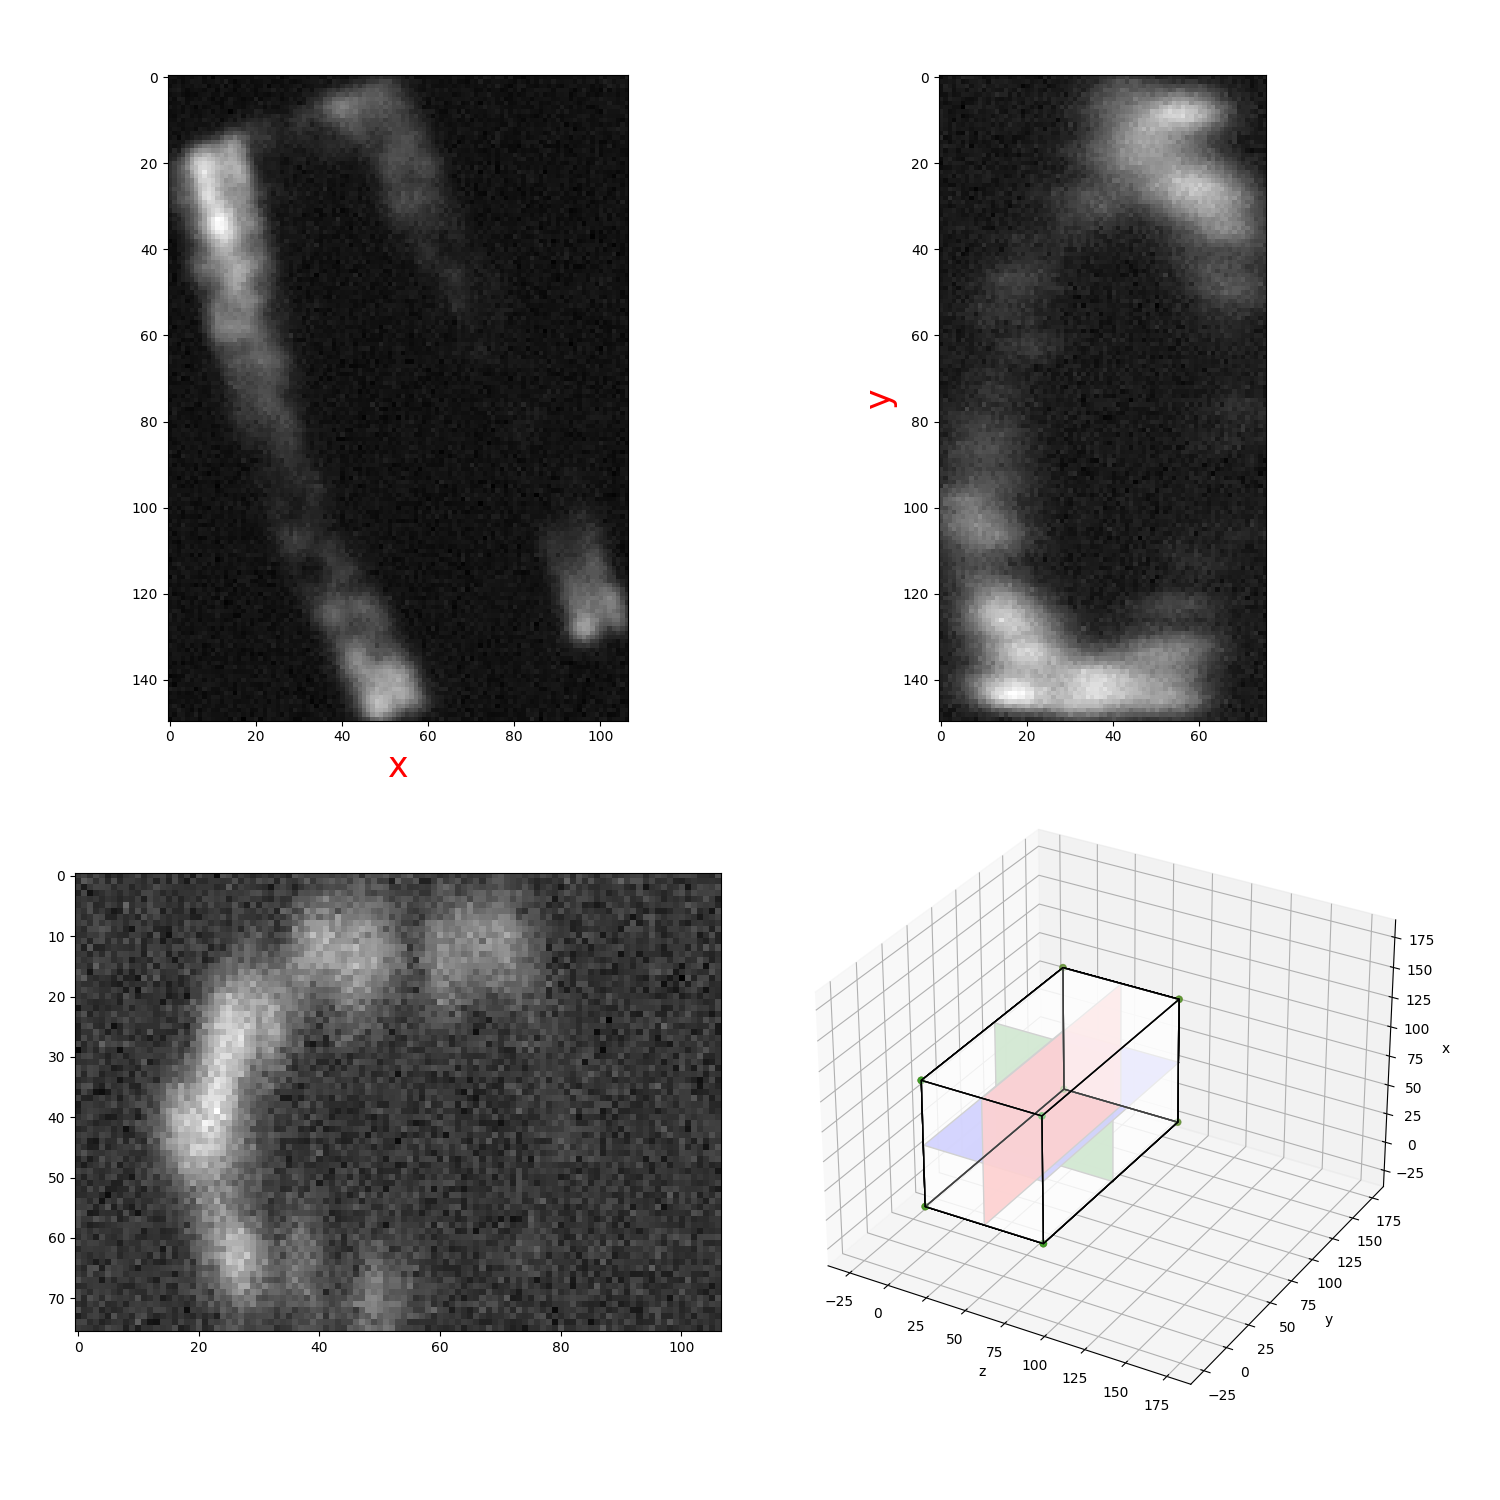

In [42]:
plot_3D_views(image, grid=False)

In [43]:
from skimage.util import random_noise

In [44]:
def add_poisson_noise(image: np.ndarray) -> np.ndarray:
    return random_noise(image, "poisson")

In [45]:
image = add_poisson_noise(image)

<IPython.core.display.Javascript object>


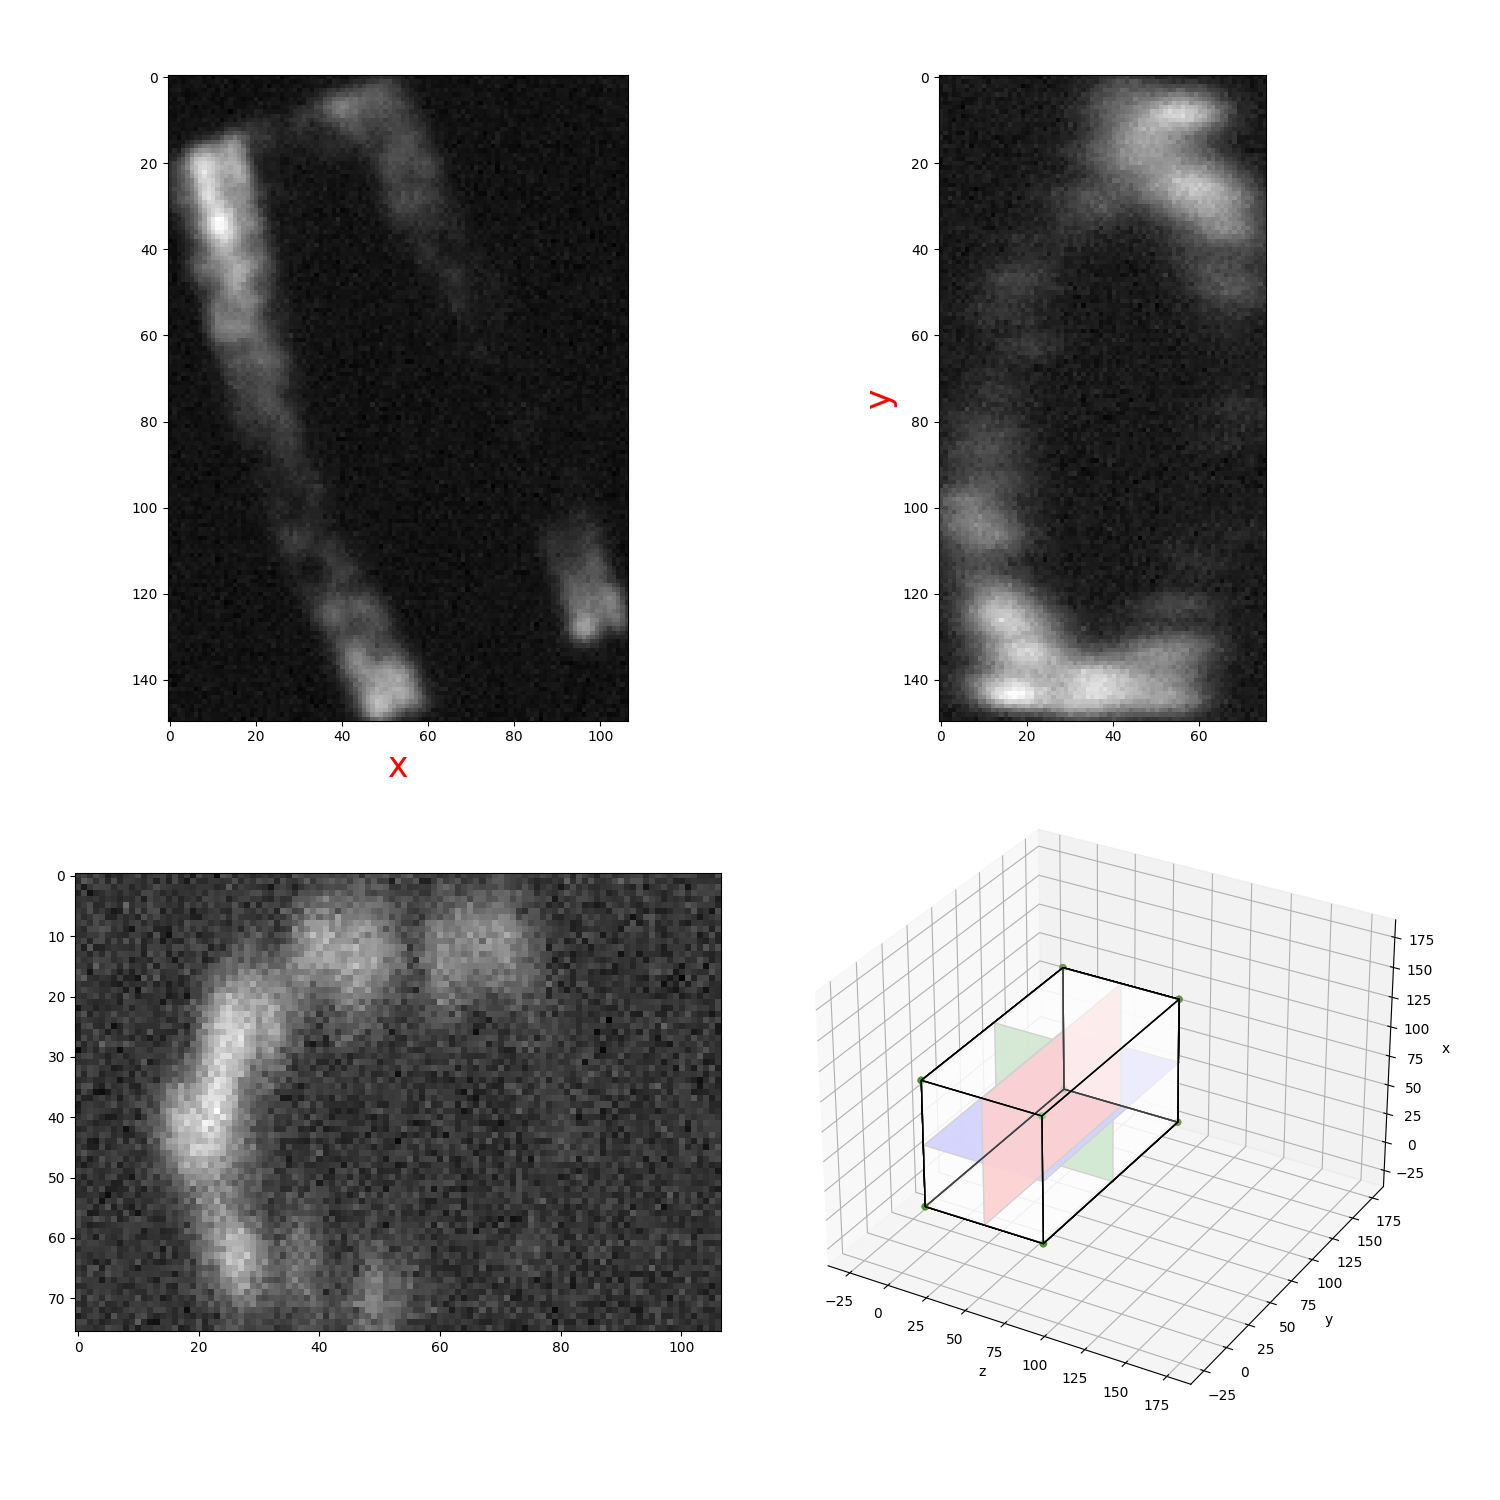

In [46]:
plot_3D_views(image, grid=False)

## Test PCA - no noise

In [47]:
point_cloud = point_cloud.cpu().numpy()

In [60]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca.fit(point_cloud)

print(pca.components_)
print(pca.explained_variance_ratio_)
print(pca.mean_)

[[ 0.89959932  0.37587592 -0.22234737]]
[0.79688174]
[ -6.55761878 -14.58709364  -0.28401059]


<IPython.core.display.Javascript object>


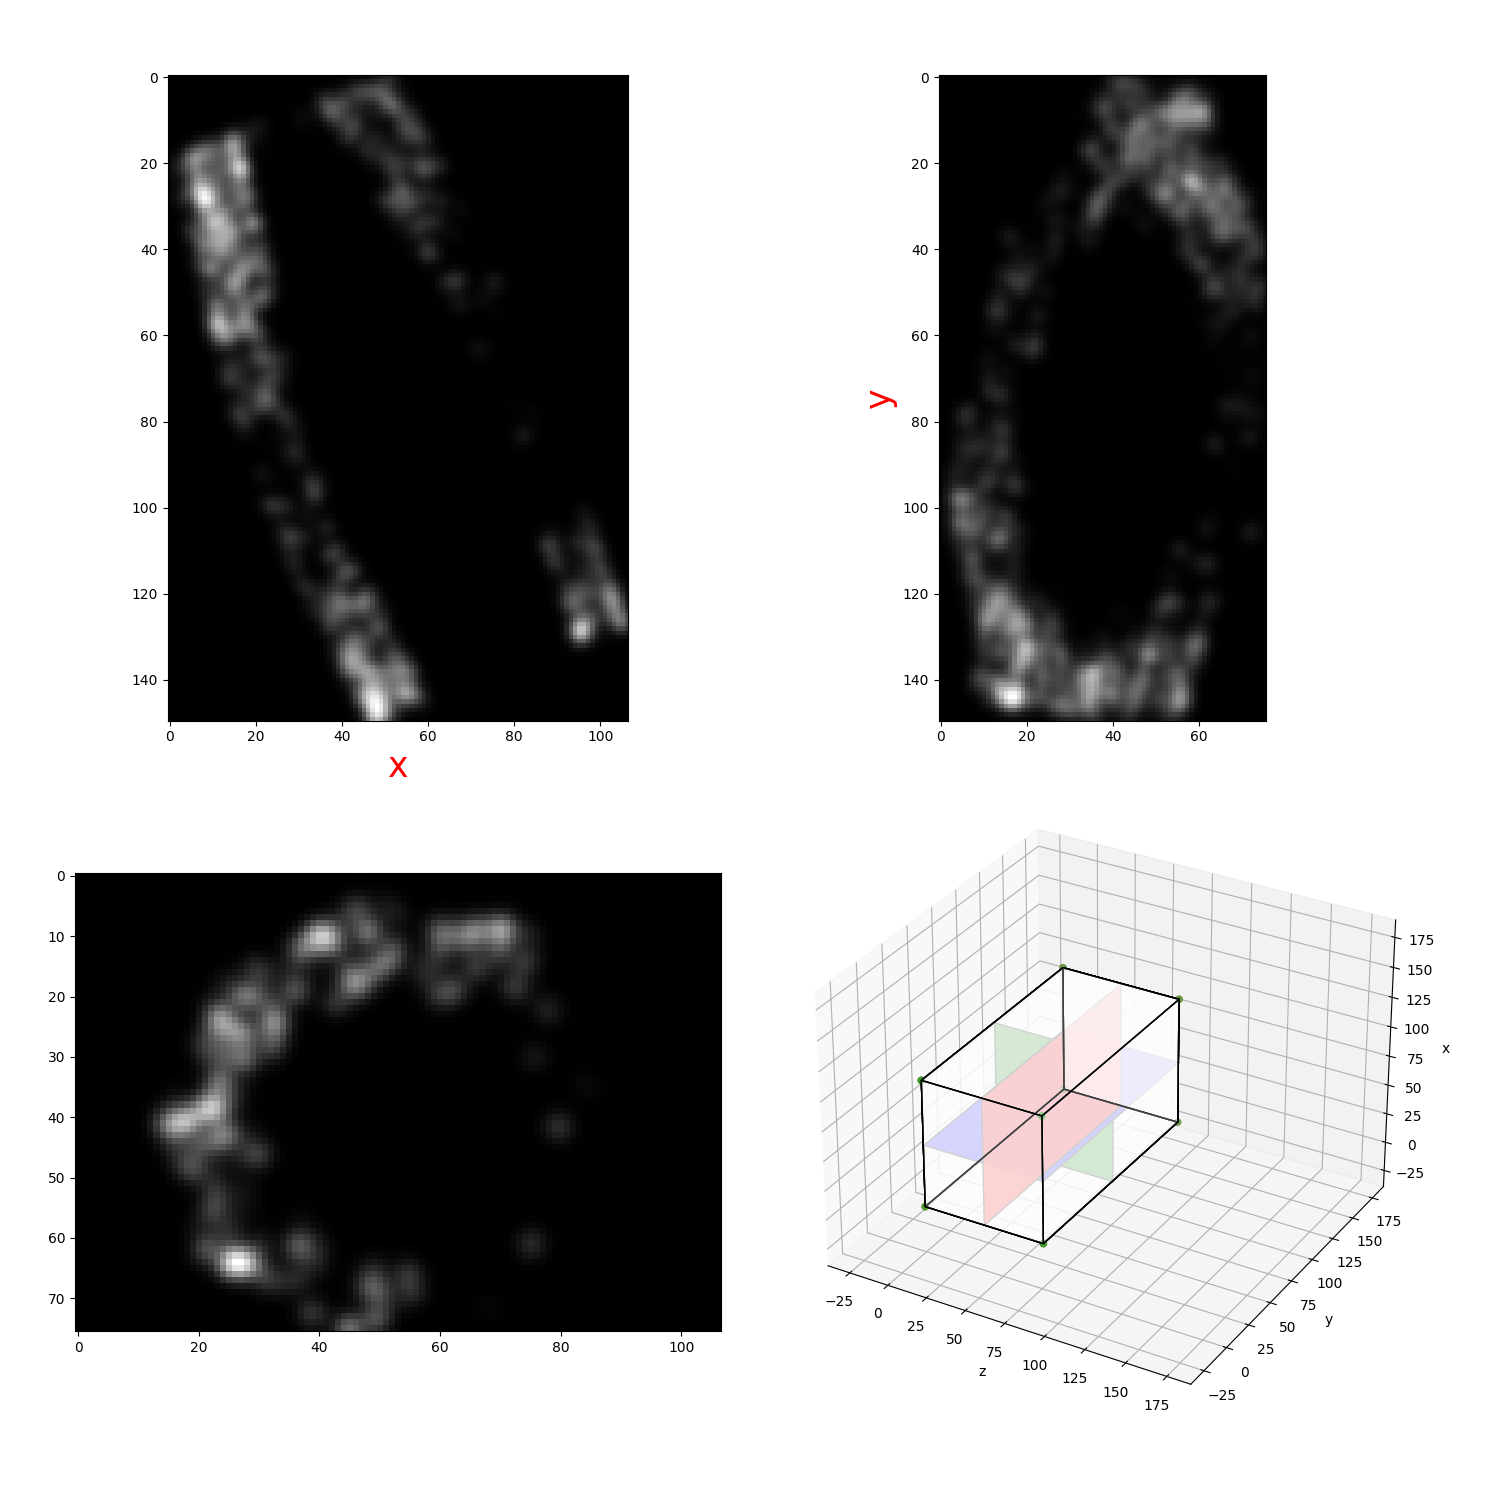

In [49]:
image = image_from_pointcloud(point_cloud, max_particle_dim)
plot_3D_views(image, grid=False)

<IPython.core.display.Javascript object>


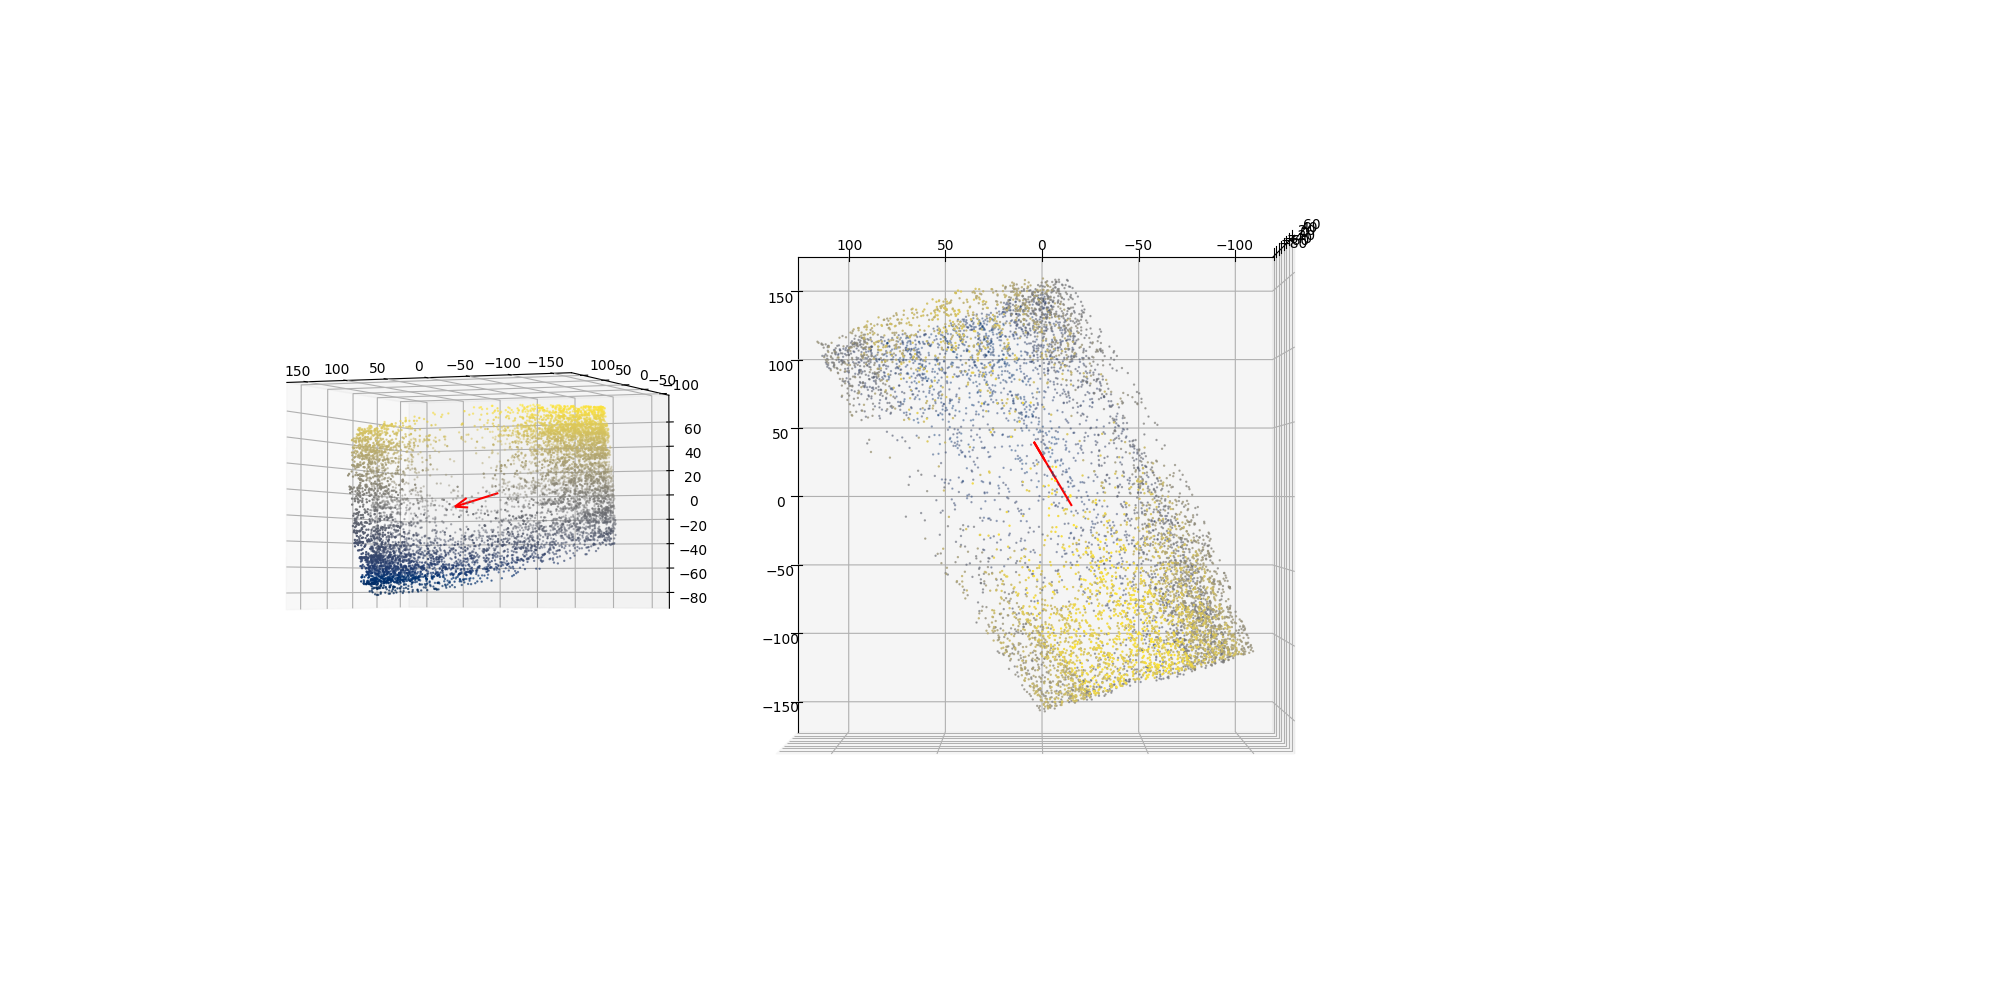

In [61]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(111, projection='3d', elev=90, azim=180)
ax2 = fig.add_subplot(131, projection='3d', elev=45, azim=180)

plot_3d(point_cloud, ax=ax1, size=0.5)
plot_3d(point_cloud, ax=ax2, size=0.5)

v0 = pca.components_[0] # principal component of the particle
ax1.quiver(pca.mean_[0], pca.mean_[1], pca.mean_[2], v0[0], v0[1], v0[2], length=50, color="red")
ax2.quiver(pca.mean_[0], pca.mean_[1], pca.mean_[2], v0[0], v0[1], v0[2], length=50, color="red")

plt.show()